|**Name**| **ID #** | **Email** | **When Midterm**| 
| :--     |  :--      |  :--    | :--             |           
|Xuan Xu |   111675940 | xuaxu@cs.stonybrook.edu        | 10/9                |             
|Hae-Na Lee| 111207004 | haenalee@cs.stonybrook.edu | 10/13, 10/23 |            
|Caitao Zhan| 111634527| caitao.zhan@stonybrook.edu | 10/16  |



In [9]:
# import all packages needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime, time
import copy
import random

from sklearn.metrics.pairwise import manhattan_distances as man_dis
from sklearn.metrics.pairwise import euclidean_distances as euc_dis

from sklearn.cluster import KMeans

In [ ]:
# Separately maintain both the raw data and its cleaned version.

df_house16 = pd.read_csv('../data/properties_2016.csv')
df_train16 = pd.read_csv('../data/train_2016_v2.csv')

#df_house17 = pd.read_csv('../data/properties_2017.csv')
#df_train17 = pd.read_csv('../data/train_2017.csv')

# Task 1

In [4]:
# Read the property data
property_data_2016 = df_house16
property_data_2017 = df_house17

In [5]:
# Extract the features to analyze
feature_list = ['parcelid','bedroomcnt','buildingqualitytypeid',
                'calculatedbathnbr','calculatedfinishedsquarefeet',
                'latitude','longitude','lotsizesquarefeet',
                'yearbuilt','structuretaxvaluedollarcnt']

feature_data_2016 = property_data_2016[feature_list]
feature_data_2017 = property_data_2017[feature_list]

In [6]:
# Read the training data
train_2016 = df_train16
train_2017 = df_train17

In [7]:
# Combine the feature data and training data
model_dataset_2016 = pd.merge(feature_data_2016, train_2016, on='parcelid')
model_dataset_2017 = pd.merge(feature_data_2017, train_2017, on='parcelid')

# Fill in missing feature data with mean values
model_dataset_filled_2016 = model_dataset_2016.fillna(model_dataset_2016.mean())
model_dataset_filled_2017 = model_dataset_2017.fillna(model_dataset_2017.mean())

In [8]:
model_dataset = [model_dataset_filled_2016, model_dataset_filled_2017]
model_dataset = pd.concat(model_dataset, ignore_index=True)

In [9]:
# Preprocessing
model_dataset_norm = model_dataset

# Normalize the features with skewed distributions
model_dataset_norm.calculatedbathnbr = np.log(model_dataset_norm.calculatedbathnbr)
model_dataset_norm.calculatedfinishedsquarefeet = np.log(model_dataset_norm.calculatedfinishedsquarefeet)
model_dataset_norm.lotsizesquarefeet = np.log(model_dataset_norm.lotsizesquarefeet)
#model_dataset_norm.roomcnt = np.log(model_dataset_norm.roomcnt)
model_dataset_norm.structuretaxvaluedollarcnt = np.log(model_dataset_norm.structuretaxvaluedollarcnt)

In [10]:
from sklearn import preprocessing

model_dataset_norm.loc[:,'bedroomcnt':'structuretaxvaluedollarcnt'] = \
 preprocessing.scale(model_dataset_norm.loc[:,'bedroomcnt':'structuretaxvaluedollarcnt'])

In [11]:
feature_list = ['parcelid','bedroomcnt','buildingqualitytypeid',
                'calculatedbathnbr','calculatedfinishedsquarefeet',
                'lotsizesquarefeet',#'roomcnt',
                'yearbuilt','structuretaxvaluedollarcnt','transactiondate']

scoring_dataset = model_dataset_norm[feature_list]

desirability_score = pd.DataFrame(scoring_dataset.bedroomcnt
 - scoring_dataset.buildingqualitytypeid
 + scoring_dataset.calculatedbathnbr
 + scoring_dataset.calculatedfinishedsquarefeet
 + scoring_dataset.lotsizesquarefeet
 + scoring_dataset.yearbuilt
 + scoring_dataset.structuretaxvaluedollarcnt, columns=['score'])

In [12]:
# Append the desirability score to the dataset
scoring_result = pd.concat([scoring_dataset, desirability_score], axis=1)

In [13]:
# Sort based on scores
scoring_result_ordered = scoring_result.sort_values('score', ascending=False)

In [14]:
# Get the ten most desirable houses in the dataset
most_desirables = scoring_result_ordered[:10]
most_desirables = scoring_result_ordered.head(n=10)

print(most_desirables['buildingqualitytypeid'].mean())
most_desirables

-0.7071146176209302


,parcelid,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,transactiondate,score
141942,10862245,6.055848,0.339878,3.912069,5.338689,2.561337,0.988559,4.922572,2017-08-30,23.439196
60710,11650918,4.315227,-0.292207,3.434757,5.281846,2.402344,1.747990,5.050215,2016-01-11,22.524585
144297,11655139,3.444916,0.339878,4.309422,5.739236,2.787843,1.072940,5.269655,2017-04-07,22.284133
87193,11654953,3.444916,-0.292207,4.649799,5.673003,2.002286,1.326084,4.601712,2016-10-20,21.990007
115381,11641869,4.315227,0.339878,3.912069,5.878335,1.424656,1.410465,4.744048,2017-02-01,21.344922
61813,11670010,3.444916,-3.272181,3.685366,4.117994,0.474359,1.916753,4.409567,2016-12-29,21.321135
3971,11650903,5.185538,-0.292207,3.685366,4.768280,0.815932,1.452656,4.842481,2016-07-11,21.042459
79388,10883206,7.796470,-1.313993,3.154600,3.361436,0.881665,1.705800,2.331928,2016-09-27,20.545892
133332,11706270,11.277714,-1.313993,3.154600,2.637588,-0.587304,0.735415,1.464498,2017-07-20,19.996504
88506,10837531,7.796470,-1.313993,3.154600,2.883729,0.881665,1.621418,1.619915,2016-08-16,19.271790


In [15]:
# Get the ten least desirable houses in the dataset
least_desirables = scoring_result_ordered[-10:]
least_desirables = scoring_result_ordered.tail(n=10)

print(least_desirables['buildingqualitytypeid'].mean())
least_desirables

0.2959364818476111


,parcelid,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,transactiondate,score
88130,11807594,-1.776949,2.602381,-1.791531,-2.559796,-1.364967,-1.880403,-2.654792,2016-04-22,-14.630819
81433,12660907,-2.647260,-1.313993,0.821613,-15.013332,-0.096297,0.482272,0.374094,2016-03-25,-14.764918
72306,12231898,-1.776949,0.644194,-1.791531,-3.217609,-0.970576,-1.964784,-4.534240,2016-07-15,-14.899885
44273,11330994,-1.776949,0.644194,-1.791531,-3.205881,1.261461,-0.150588,-8.936016,2016-01-06,-15.243699
76819,11810855,-2.647260,-0.292207,0.199127,-5.172037,-0.526313,-1.964784,-6.073198,2016-10-07,-15.892259
41121,12059289,-1.776949,0.644194,-1.791531,-3.114202,-1.313725,-1.964784,-5.868466,2016-06-20,-16.473853
89349,11524235,-2.647260,-0.292207,0.199127,-8.285421,1.052183,1.537037,-8.887253,2016-02-26,-16.739380
157491,12664381,-2.647260,0.339878,0.206507,-5.673180,0.063147,-0.825638,-8.198329,2017-02-10,-17.414630
3631,10979838,-2.647260,0.644194,-1.791531,-2.761598,-1.231372,-1.880403,-6.693889,2016-03-08,-17.650248
90781,11589514,-1.776949,-0.661264,-1.791531,-2.310925,-1.363869,-2.682025,-8.448588,2017-03-13,-17.712624


# 2 Task Two: Design Pairwise Distance Function

Many algorithms in machine learning and data mining require a *pairwise distance function (distance function)* as a basic component. This chapter shows our insights and efforts on building decent distance functions. **First** we fill elaborate on our four steps of designing a distance function. **Then** introduce a baseline distance function. **Finally** we will introduce an advanced distance function.## 2.1 Four Steps
We break down designing a pairwise distance function into four steps, as follows:

## 2.1 Four Steps
We break down designing a pairwise distance function into four steps, as follows:

| Step | Description | Memo |
|:--|:--|:--|
|1| feature selection| curse of high dimension :( |
|2| impute missing value| what is the distance between two NaN ?! |
|3| normalization| z-score ~ |
|4| what kind of distance| $L_k\ (k = ?)$|

### 2.1.1 Feature Selection

In high dimensional space, the concept of proximity, distance or nearest neighbor may not be qualitatively meaningful[[1]]. For example, in high dimensions, the performance of similarity indeing structures degrades rapidly, thus each query requires the access of almost all the data[[2]]. In english, this is known as *curse of dimensionality*[[3]]. 

`[1]`: Charu C. Aggarwal, Alexander Hinneburg, and Daniel A. Keim. "On the Surprising Behavior of Distance Metrics in High Dimensional Space".

`[2]`: Weber R., Schek H.-J., Blott S.. "A Quantitative Analysis and Performance Study for Similarity-Search Methods in High-Dimensional Spaces". VLDB Conference Proceedings, 1998.

`[3]`: Wikipedia: Curse_of_dimensionality


[1]:https://bib.dbvis.de/uploadedFiles/155.pdf
[2]:https://pdfs.semanticscholar.org/63ea/eb0c48175065ffd096aad10aed712c6d7bbb.pdf
[3]:https://en.wikipedia.org/wiki/Curse_of_dimensionality



### 2.1.2 Distance Between Missing Values

The **distance between two missing values** is an annoying part when designing a distance function. Of course, an easy way is replacing all the *NaN* with *mean*. But we do not think this is a good idea. The reason is as follows:

**mean == mean**, but **np.nan != np.nan**.

Suppose there is a feature named *bathroomcnt*. So, when replacing *NaN* with *mean*, then the distance of two *bathroomcnt = NaN* will be zero (*mean* - *mean* = 0). However, we believe the distance should not be zero. The distance should be zero, for example, when two houses both have 2 bathrooms.

### 2.1.3 Normalization

If we do not normalize our variables before computing distances, there will be serious biases and screw up the distance metrics. Thus, we have to first normalize the values of each dimension by Z-scores, then compute distances.

$$Z_i = (a_i-\mu )/\sigma $$

where $\mu$ is the mean of the distribution and $\sigma$ the associated standard deviation.

### 2.1.4 What Kind of Distance

*Manhatten* distance and *euclidian* distance are two commonly used distances. Actually, they are just two special cases of $L_K$ distance metric or norm, where *K=1* and *K=2* respectively.

Research results[[1]] show that Manhattan distance metric ($L_1$ norm) is consistently more preferable than the Euclidean distance metric ($L_2$ norm) for high dimensional data science applications.

[1]:https://bib.dbvis.de/uploadedFiles/155.pdf

`[1]`: Charu C. Aggarwal, Alexander Hinneburg, and Daniel A. Keim. "On the Surprising Behavior of Distance Metrics in High Dimensional Space".

## 2.2 Baseline Distance Function

### 2.2.1 Location, Location, Location

Britain real estate tycoon Harold Samuel said: 'There are three things that matter in property: location, location, location.' Let's visualize where are the locations of the properties in the data provided by [Kaggle](https://www.kaggle.com/c/zillow-prize-1/data).

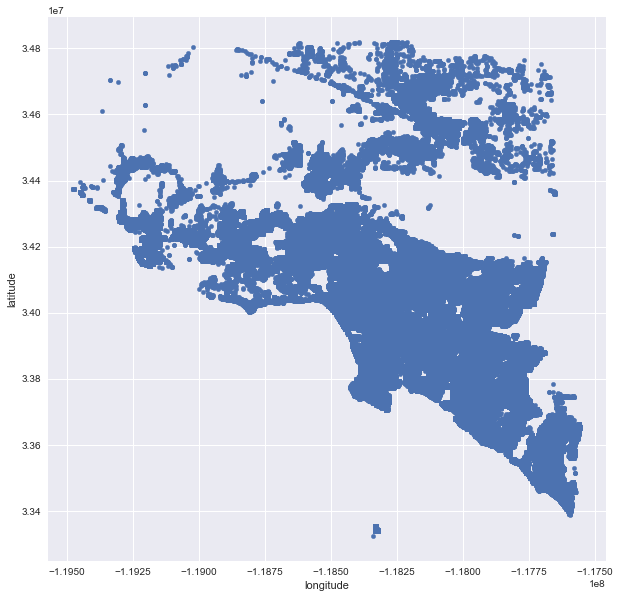

In [3]:
X = 'longitude'
Y = 'latitude'

df_ll = df_house16.loc[:,[X, Y]]
df_ll.dropna(how='any', inplace=True)
df_ll.plot(x=X, y=Y, kind='scatter', figsize=(10,10))

![los angeles](./figure/los_angeles.png)

After visualizing *longitude* and *latitude* and comparing them to google maps, we can find out that all the properties are in the greater Los Angeles area. Our **baseline distance function** will **only be based on locations: (longitude, latitude)**.

### 2.2.2 Replace *NaN* with a *Random* Value

We believe the **distance between two *NaN* should not be *zero***. If we replace all the *NaN* with *mean*, then the distance will be *mean* - *mean* = *0*.

After hard thinking, we finally decide to use the **random value imputation** method to replace *NaN*. It replaces *NaN* with a random value **sampled from its column (feature)**. Then the distance between two original *NaN* will be a *random value*. This will be a lot better than a *zero* distance.

Furthermore, if one is a numeric number and the other is *NaN*, then the distance will be that numeric value minus a random value sampled from its column.

In [4]:
def randomSampleImpute(df, feature_list):
    """ Replace NaN with a random value sampled from its column(feature).
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        nan_indexes = np.argwhere(np.isnan(df[col]))             # which rows have NaN, array
        valid_series = df[col].dropna()                          # drop the NaN, Series
        random_values = valid_series.sample(n=nan_indexes.size)  # random samples, Series
        
        for nan_index, random_value in zip(nan_indexes, random_values):
            df.iat[nan_index[0], df.columns.get_loc(col)] = random_value  # replace NaN

### 2.2.3 Normalization

In [5]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

### 2.2.4 The Distance Function

In [6]:
def pairwise_distance_baseline(s1, s2, feature_list):
    """ Compute the distance between two series using euclidian distance. 
    
    Args:
        s1 (Series): a row in a dataframe, i.e. a property.
        s2 (Series): a row in a dataframe, i.e. a property.
    """
    X  = feature_list[0]
    Y  = feature_list[1]
    x1 = s1.at[X]
    y1 = s1.at[Y]
    x2 = s2.at[X]
    y2 = s2.at[Y]
    return euc_dis([[x1,y1]], [[x2,y2]])

### 2.2.5 Example 
In this section, we will caculate the distance between two randomly selected properites. 

First clean the data.

In [8]:
# Operate the raw data and cleaned data separately.
df_house16_clean = copy.deepcopy(df_house16)

In [9]:
feature_list = ['longitude', 'latitude']
randomSampleImpute(df_house16_clean, feature_list)   # Missing value imputation
z_score_norm(df_house16_clean, feature_list)         # Normalization

Then calculate the distance between two randomly selected properties.

In [14]:
row1 = random.randint(0, 2985217)
row2 = random.randint(0, 2985217)

dis = pairwise_distance_baseline(df_house16_clean.iloc[row1], df_house16_clean.iloc[row2], feature_list)
print('The distance between #%d and #%d is %f' % (row1, row2, dis))

The distance between #693607 and #1955271 is 1.175066


In [15]:
del df_house16_clean                                 # release memory

# Task 3: Clustering

In [6]:
feature_list = ['longitude', 'latitude']
df_ll = df_house16[feature_list]

In [ ]:
randomSampleImpute(df_ll, feature_list)
z_score_norm(df_ll, feature_list)

In [10]:
kmeans = KMeans(init='k-means++', n_clusters=15)
kmeans.fit(df_ll)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

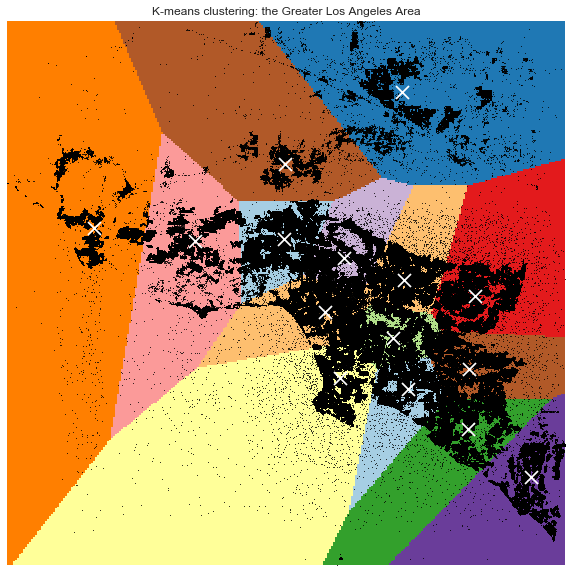

In [11]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = df_ll.iloc[:, 0].min(), df_ll.iloc[:, 0].max()
y_min, y_max = df_ll.iloc[:, 1].min(), df_ll.iloc[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(df_ll.iloc[:, 0], df_ll.iloc[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering: the Greater Los Angeles Area')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()